# LA Galaxy - Default Retention Model
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 14, 2022

## Hypothesis
This notebook contains the data pre-processing, model training and evaluation of the Coyotes retention model with the default StellarAlgo features. We think that the distToVenue feature could be a significant indicator for Full Season ticket buyers.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 6 # galaxy
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(25743, 54)

### Let's specify the default SA features for our model:

In [4]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14111, 9)
Unseen Data For Predictions: (2490, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [6]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    exclude=["lda","qda"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7490,0.8122,0.8484,0.7515,0.7970,0.4713,0.4774,0.5180
gbc,Gradient Boosting Classifier,0.7449,0.8115,0.8547,0.7442,0.7956,0.4605,0.4685,0.1100
ada,Ada Boost Classifier,0.7415,0.8012,0.8580,0.7390,0.7941,0.4522,0.4615,0.0440
xgboost,Extreme Gradient Boosting,0.7398,0.8031,0.8330,0.7478,0.7881,0.4536,0.4582,0.3650
rf,Random Forest Classifier,0.7309,0.7945,0.8171,0.7445,0.7791,0.4367,0.4399,0.2320
et,Extra Trees Classifier,0.7251,0.7827,0.8073,0.7422,0.7734,0.4257,0.4282,0.1850
lr,Logistic Regression,0.6920,0.7374,0.7900,0.7117,0.7486,0.3537,0.3574,0.1270
knn,K Neighbors Classifier,0.6849,0.7183,0.7880,0.7047,0.7439,0.3378,0.3415,0.1440
ridge,Ridge Classifier,0.6845,0.0000,0.7753,0.7089,0.7406,0.3401,0.3425,0.0050
nb,Naive Bayes,0.6697,0.7264,0.8570,0.6718,0.7483,0.2820,0.3119,0.0100


[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5415 val_loss=0.0000 scale=2.0000 norm=3.7059
[iter 200] loss=0.5213 val_loss=0.0000 scale=2.0000 norm=3.7813
[iter 300] loss=0.5146 val_loss=0.0000 scale=2.0000 norm=3.8112
[iter 400] loss=0.5119 val_loss=0.0000 scale=2.0000 norm=3.8288


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5410 val_loss=0.0000 scale=2.0000 norm=3.7042
[iter 200] loss=0.5199 val_loss=0.0000 scale=1.0000 norm=1.8910
[iter 300] loss=0.5140 val_loss=0.0000 scale=2.0000 norm=3.8061
[iter 400] loss=0.5108 val_loss=0.0000 scale=1.0000 norm=1.9125


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5395 val_loss=0.0000 scale=2.0000 norm=3.6993
[iter 200] loss=0.5201 val_loss=0.0000 scale=2.0000 norm=3.7662
[iter 300] loss=0.5143 val_loss=0.0000 scale=2.0000 norm=3.7951
[iter 400] loss=0.5113 val_loss=0.0000 scale=2.0000 norm=3.8128
[iter 0] loss=0.6801 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5417 val_loss=0.0000 scale=2.0000 norm=3.7055
[iter 200] loss=0.5213 val_loss=0.0000 scale=1.0000 norm=1.8920
[iter 300] loss=0.5149 val_loss=0.0000 scale=1.0000 norm=1.9084
[iter 400] loss=0.5131 val_loss=0.0000 scale=0.5000 norm=0.9582


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5377 val_loss=0.0000 scale=2.0000 norm=3.6954
[iter 200] loss=0.5175 val_loss=0.0000 scale=2.0000 norm=3.7738
[iter 300] loss=0.5118 val_loss=0.0000 scale=1.0000 norm=1.9035
[iter 400] loss=0.5086 val_loss=0.0000 scale=1.0000 norm=1.9116


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5399 val_loss=0.0000 scale=2.0000 norm=3.7035
[iter 200] loss=0.5187 val_loss=0.0000 scale=2.0000 norm=3.7814
[iter 300] loss=0.5130 val_loss=0.0000 scale=2.0000 norm=3.8219
[iter 400] loss=0.5111 val_loss=0.0000 scale=0.5000 norm=0.9593


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.84e-09): result may not be accurate.
  overwrite_a=True).T
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5389 val_loss=0.0000 scale=2.0000 norm=3.6983
[iter 200] loss=0.5184 val_loss=0.0000 scale=1.0000 norm=1.8841
[iter 300] loss=0.5108 val_loss=0.0000 scale=1.0000 norm=1.8997
[iter 400] loss=0.5075 val_loss=0.0000 scale=1.0000 norm=1.9080


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-package

[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5404 val_loss=0.0000 scale=2.0000 norm=3.7012
[iter 200] loss=0.5201 val_loss=0.0000 scale=2.0000 norm=3.7798
[iter 300] loss=0.5137 val_loss=0.0000 scale=1.0000 norm=1.9021
[iter 400] loss=0.5105 val_loss=0.0000 scale=1.0000 norm=1.9097
[iter 0] loss=0.6800 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5414 val_loss=0.0000 scale=2.0000 norm=3.7038
[iter 200] loss=0.5203 val_loss=0.0000 scale=2.0000 norm=3.7858
[iter 300] loss=0.5143 val_loss=0.0000 scale=1.0000 norm=1.9042
[iter 400] loss=0.5113 val_loss=0.0000 scale=1.0000 norm=1.9120


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6801 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5401 val_loss=0.0000 scale=2.0000 norm=3.7030
[iter 200] loss=0.5197 val_loss=0.0000 scale=2.0000 norm=3.7880
[iter 300] loss=0.5131 val_loss=0.0000 scale=2.0000 norm=3.8125
[iter 400] loss=0.5105 val_loss=0.0000 scale=0.5000 norm=0.9566


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

### Now that we have the best performing model, we can finalize it:

In [7]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7633,0.8269,0.8637,0.7611,0.8091,0.5010,0.5080
1,0.7442,0.8212,0.8508,0.7450,0.7944,0.4598,0.4669
2,0.7392,0.8085,0.8393,0.7443,0.7889,0.4508,0.4564
3,0.7567,0.8138,0.8407,0.7640,0.8005,0.4904,0.4941
4,0.7515,0.8116,0.8451,0.7561,0.7981,0.4775,0.4825
5,0.7640,0.8231,0.8752,0.7568,0.8117,0.4999,0.5095
6,0.7506,0.8126,0.8362,0.7588,0.7956,0.4778,0.4815
7,0.7314,0.7939,0.8348,0.7373,0.7830,0.4343,0.4400
8,0.7548,0.8155,0.8491,0.7577,0.8008,0.4846,0.4900
9,0.7339,0.7944,0.8491,0.7342,0.7875,0.4368,0.4451


### Let's load in our 2021 season data and get retention scores using the model:

In [8]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(4932, 54)

In [9]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
20811,6,450019493,98920122,2021,Full Season,461.5,2021-11-07,0.750000,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,0,1,0.4625,0.5375
20812,6,450019565,9228651,2021,Full Season,585.0,2021-11-07,1.083333,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,0,0.5366,0.4634
20813,6,450019566,20769777,2021,Full Season,3081.0,2021-11-07,1.000000,290.0,TRUE,...,Completed High School,0,0.0,1,24,0,1,1,0.2444,0.7556
20814,6,450019977,8036052,2021,Full Season,0.0,1970-01-01,0.000000,0.0,FALSE,...,Completed High School,0,0.0,1,24,0,1,0,0.9763,0.0237
20815,6,450020766,"8238647, 68989503",2021,Full Season,3575.0,2021-11-07,0.864583,290.0,TRUE,...,Completed College,0,0.0,1,24,0,1,1,0.4769,0.5231


In [10]:
new_predictions['Label'].value_counts()

1    3092
0    1840
Name: Label, dtype: int64

### We can plot the scores using a histogram to see the score distribution for buyers:

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

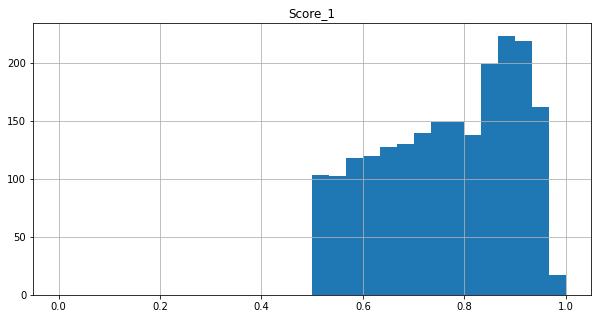

In [11]:
new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

### Let's plot the feature importances to see what features in the model are most predictive:

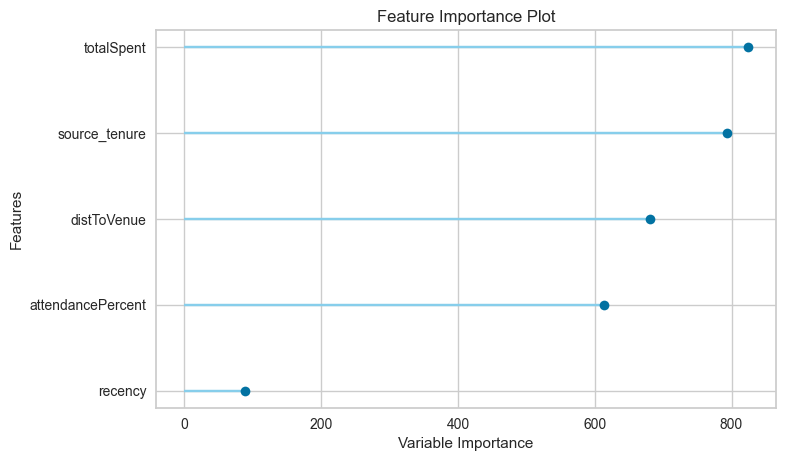

In [12]:
plot_model(best_model, plot='feature')

### Using a confusion matrix can also help us understand where the model is predicting correctly and where it's missing:

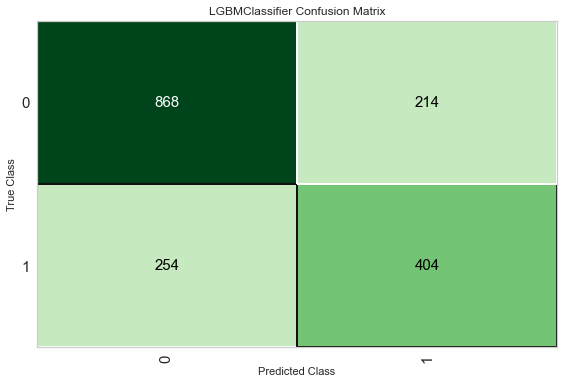

In [23]:
plot_model(best_model, plot='confusion_matrix')

### Let's also visualize the AUC (area under the curve) to get a sense of how our model is performing:

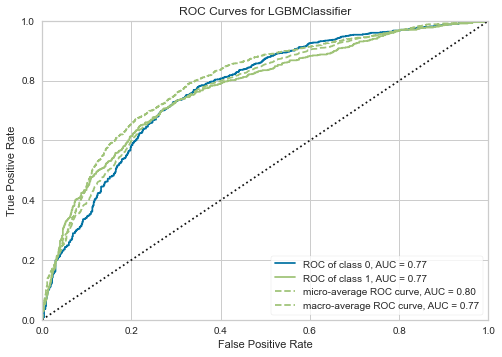

In [76]:
plot_model(best_model, plot="auc")

## Observations

* The model predictions are ~ 75% accurate 

* The Full Season ticket buyers fall into a Normal Distribution, as is expected.

* distToVenue is the third most important feature, with a variable importance ~ 75%

* The model made 3x as many correct predictions vs. incorrect predictions

## Conclusions

The distToVenue feature did prove to be a useful feature for model predictions. The next experiment will focus on altering the distToVenue feature to understand the impact (or non-impact) on model performance (i.e. does adding distance to the feature improve accuracy or have little to no impact).